<a href="https://colab.research.google.com/github/Weifeng-Ke/Machine-Learning/blob/main/Programming_Assignment_2/CPEN455_2024W02_Assignment_2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# prompt: mount to google drive

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CPEN_455/Assignment_2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CPEN_455/Assignment_2


In [14]:
import torch
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

In [15]:
class SubstringDataset(Dataset):
    LETTERS = list('cpen')

    def __init__(self, seed, dataset_size, str_len=20):
        super().__init__()
        self.str_len = str_len
        self.dataset_size = dataset_size
        self.rng = np.random.default_rng(seed)
        self.strings, self.labels = self._create_dataset()

    def __getitem__(self, index):
        return self.strings[index], self.labels[index]

    def __len__(self):
        return self.dataset_size

    def _create_dataset(self):
        strings, labels = [], []
        for i in range(self.dataset_size):
            label = i%2
            string = self._generate_random_string(bool(label))
            strings.append(string)
            labels.append(label)
        return strings, labels

    def _generate_random_string(self, has_cpen):
        while True:
            st = ''.join(self.rng.choice(SubstringDataset.LETTERS, size=self.str_len))
            if ('cpen' in st) == has_cpen:
                return st

In [16]:
class Tokenizer():
    def __init__(self) -> None:
        self.vocab = {
            '[CLS]': 0,
            'c': 1,
            'p': 2,
            'e': 3,
            'n': 4,
        }

    def tokenize_string(self, string, add_cls_token=True) -> torch.Tensor:
        """
        Tokenize the input string according to the above vocab

        START BLOCK
        """
        tokens=[]
        token_ids=[]
        #take care the case where cls is included, if so put a 0 into the token_id
        if add_cls_token:
            tokens.append(self.vocab['[CLS]'])
        #step 1 split the string and return a list of characters
        #split the string into individual characters
        tokens.extend(list(string))

        #convert each token into corresponding token_id using the vocab
        for token in tokens:
          if token == 0:
              token_ids.append(0)
          else:
              token_ids.append(self.vocab[token])

        # creat one hot matrix for token ids
        #the number of tokens is the length of the token_ids length which is n+1
        num_tokens=len(token_ids)
        #dvoc is the length of the volcabulary
        dvoc=len(self.vocab)
        #the one hot matrix has the size of R^(n+1)x dvoc
        one_hot=torch.zeros(num_tokens,dvoc)

        #convert the list of tokens into one hot
        token_ids_tensor=torch.tensor(token_ids)
        #this f.one_hot funtion takes in a token_id tensor as input, the second parameter is the numebr of parameter
        one_hot=F.one_hot(token_ids_tensor,num_classes=dvoc)
        #now the tokenized_string is a one hot encoding matrix
        tokenized_string = one_hot
        """
        END BLOCK
        """
        return tokenized_string

    def tokenize_string_batch(self, strings, add_cls_token=True):
        X = []
        for s in strings:
            X.append(self.tokenize_string(s, add_cls_token=add_cls_token))
        return torch.stack(X, dim=0)


In [17]:
class AbsolutePositionalEncoding(nn.Module):
    MAX_LEN = 256
    def __init__(self, d_model):
        super().__init__()
        self.W = nn.Parameter(torch.empty((self.MAX_LEN, d_model)))
        nn.init.normal_(self.W)

    def forward(self, x):
        """
        args:
            x: shape B x N x D
        returns:
            out: shape B x N x D
        START BLOCK
        """
        #Adds the positional encoding to the input embedding X
        # X has shape batch_size, sequence_length, and d_model
        B,N,D=x.shape;
        #the weight matix has the size of R ^(max_len X d_model) also we assume everying string is within max_len
        #slicing the positonal encoding matrix, unsqueeze adds a batch dimension so the positional_encoding has the dimension of R^(Batch size X max_len X d_modeld)
        positional_encoding=self.W[:N,:].unsqueeze(0)

        #element wise adding rows of this matrix to their correspindong position in the input
        out = x+positional_encoding
        """
        END BLOCK
        """
        return out

class MultiHeadAttention(nn.Module):
    MAX_LEN = 256

    def __init__(self, d_model, n_heads, rpe):
        super().__init__()
        assert d_model % n_heads == 0, "Number of heads must divide number of dimensions"
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_h = d_model // n_heads
        self.rpe = rpe
        self.Wq = nn.ParameterList([nn.Parameter(torch.empty((d_model, self.d_h))) for _ in range(n_heads)])
        self.Wk = nn.ParameterList([nn.Parameter(torch.empty((d_model, self.d_h))) for _ in range(n_heads)])
        self.Wv = nn.ParameterList([nn.Parameter(torch.empty((d_model, self.d_h))) for _ in range(n_heads)])
        self.Wo = nn.Parameter(torch.empty((d_model, d_model)))

        if rpe:
            # -MAX_LEN, -MAX_LEN+1, ..., -1, 0, 1, ..., MAX_LEN-1, MAXLEN
            self.rpe_w = nn.ParameterList([nn.Parameter(torch.empty((2*self.MAX_LEN+1, ))) for _ in range(n_heads)])

        for h in range(self.n_heads):
            nn.init.xavier_normal_(self.Wk[h])
            nn.init.xavier_normal_(self.Wq[h])
            nn.init.xavier_normal_(self.Wv[h])
            if rpe:
                nn.init.normal_(self.rpe_w[h])
        nn.init.xavier_normal_(self.Wo)

    def forward(self, key, query, value):
        """
        args:
            key: shape B x N x D
            query: shape B x N x D
            value: shape B x N x D
        return:
            out: shape B x N x D
        START BLOCK
        """
        B, N, D = query.shape
        head_outputs = []  # To collect outputs from each head

        for h in range(self.n_heads):
            #first compute the X times Wq,Wk,and Wv
            Q = torch.matmul(query, self.Wq[h])  # (B, N, d_h)
            K = torch.matmul(key, self.Wk[h])      # (B, N, d_h)
            V = torch.matmul(value, self.Wv[h])    # (B, N, d_h)

            #feed thist into the attention block
            # Compute scaled dot-product for Q times K.transpose: (B, N, N)
            scores = torch.bmm(Q, K.transpose(1, 2))

            #need to account for if the token are position encodede
            if self.rpe:
                # Create relative position indices: shape (N, N)
                pos_indices = (
                    torch.arange(N, device=query.device).unsqueeze(0) -
                    torch.arange(N, device=query.device).unsqueeze(1)
                )
                # Shift indices to be non-negative: values in [0, 2*MAX_LEN]
                pos_indices = pos_indices + self.MAX_LEN
                # Lookup relative bias for head h: shape (N, N)
                relative_bias = self.rpe_w[h][pos_indices]
                # Expand to batch dimension and add to scores
                scores = scores + relative_bias.unsqueeze(0)

            # Scale scores by dividing the dimension of the head attention for statble gradiens
            scores = scores / (self.d_h ** 0.5)
            #Attention (Q,K,V)= softmax(Q*K^(T)/(sqrt(d_h)))*V; Compute attention weights with softmax: shape (B, N, N)
            attention_weights = torch.softmax(scores, dim=-1)
            #output = attention weight times the xv * wv
            # Compute weighted sum of values: shape (B, N, d_h)
            head_output = torch.bmm(attention_weights, V)
            #once we get the head_output we need to concatenate these head_output
            head_outputs.append(head_output)

        # Concatenate outputs from all heads: shape (B, N, d_model)
        concat = torch.cat(head_outputs, dim=-1)
        #afger we have all the head_output we are going to compute attention
        #attention (Xk,Xq,Xv) = concat(head1,head2,head3) * Wo
        # Final linear projection: shape (B, N, d_model)
        out = torch.matmul(concat, self.Wo)

        """
        END BLOCK
        """
        return out


Input Shape: torch.Size([2, 10, 16])
Output Shape: torch.Size([2, 10, 16])
Output Different from Input: True
Same Positional Encoding for All Batches: True
Different Positions Have Different Encodings: tensor(True)
Same Encoding for Same Position Across Batches: True


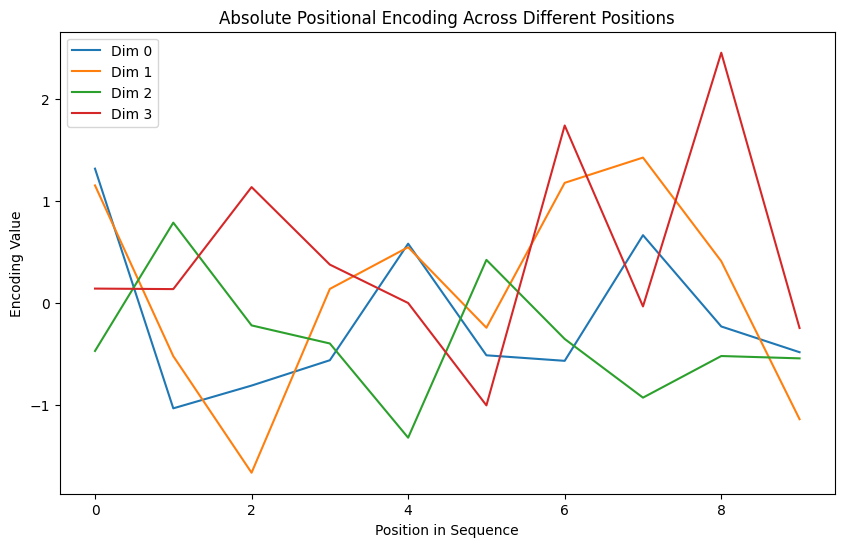

In [18]:
# Instantiate Absolute Positional Encoding
d_model = 16  # Embedding dimension
seq_len = 10  # Sequence length
batch_size = 2  # Number of samples

# Create a dummy input tensor (random embeddings)
input_tensor = torch.randn(batch_size, seq_len, d_model)

# Initialize the Positional Encoding module
pos_encoding = AbsolutePositionalEncoding(d_model)

# Pass the input tensor through the positional encoding
output = pos_encoding(input_tensor)

# Check shape consistency
print("Input Shape:", input_tensor.shape)  # Expected: (2, 10, 16)
print("Output Shape:", output.shape)  # Expected: (2, 10, 16)
# Ensure positional encoding is being added (should be different from input)
print("Output Different from Input:", not torch.allclose(input_tensor, output))

# Extract positional encodings applied to both sequences
pos_enc_1 = output[0] - input_tensor[0]  # Encoding for first batch element
pos_enc_2 = output[1] - input_tensor[1]  # Encoding for second batch element

# Check if positional encodings across different batches are the same
print("Same Positional Encoding for All Batches:", torch.allclose(pos_enc_1, pos_enc_2))

# Create a tensor with zeros to isolate positional encoding effect
zero_tensor = torch.zeros(batch_size, seq_len, d_model)
pos_only_output = pos_encoding(zero_tensor)  # Only positional encoding remains

# Check if different positions have different encodings
pos_variation = torch.all(pos_only_output[:, 0, :] != pos_only_output[:, 1, :])
print("Different Positions Have Different Encodings:", pos_variation)
# Extract encodings for the first position across different batches
pos_0_batch_1 = pos_only_output[0, 0, :]
pos_0_batch_2 = pos_only_output[1, 0, :]

# Check if encoding for position 0 is the same across batches
print("Same Encoding for Same Position Across Batches:", torch.allclose(pos_0_batch_1, pos_0_batch_2))

import matplotlib.pyplot as plt

# Extract encodings for visualization
pos_encoding_values = pos_only_output[0].detach().numpy()  # Take first batch

# Plot the positional encoding for the first few dimensions
plt.figure(figsize=(10, 6))
for i in range(min(4, d_model)):  # Plot first 4 dimensions
    plt.plot(range(seq_len), pos_encoding_values[:, i], label=f'Dim {i}')

plt.xlabel("Position in Sequence")
plt.ylabel("Encoding Value")
plt.title("Absolute Positional Encoding Across Different Positions")
plt.legend()
plt.show()



I have used chat to explain to me how does pre-norm and post norm works and i reference the slide for the illustration.

In [19]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, prenorm: bool, rpe: bool):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.prenorm = prenorm
        self.attention = MultiHeadAttention(d_model, n_heads, rpe=rpe)
        self.fc_W1 = nn.Parameter(torch.empty((d_model, 4*d_model)))
        self.fc_W2 = nn.Parameter(torch.empty((4*d_model, d_model)))
        self.relu = nn.ReLU()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        nn.init.xavier_normal_(self.fc_W1)
        nn.init.xavier_normal_(self.fc_W2)

    def forward(self, x):
        """
        args:
            x: shape B x N x D
        returns:
            out: shape B x N x D
        START BLOCK
        """
        #following the pre-norm flow chart
        if self.prenorm:
            #first go through the layer norm
            attention_input = self.ln1(x)
            #coming out of the multi-head attention
            attention_output = self.attention(attention_input, attention_input, attention_input)
            #join 2 branch into 1, input + output of multi_head attention
            x = x + attention_output
            #frist go through the layer norm
            feed_forward_input = self.ln2(x)
            #the go thought the feed_forward network, the feed_forward with the has w layers, the first is the fully connected layer
            #the first layer is x*w1 and then Relu(x*w1)
            feed_forward_hidden = self.relu(torch.matmul(feed_forward_input, self.fc_W1))
            #the output of relu times w2
            feed_forward_output = torch.matmul(feed_forward_hidden, self.fc_W2)
            #add the two branch back together
            out = x + feed_forward_output
        else:
            #post norm
            #first feed directly to multi-head attention
            attention_output = self.attention(x, x, x)
            #add the two branch together and then go though the layer norm
            x=self.ln1(x+attention_output)

            #go throught the FFN and the FFN has 2 layers, the first layer is X*W1 and then relu
            feed_forward_hidden = self.relu(torch.matmul(x, self.fc_W1))
            #the second layer is RElu()*W2
            feed_forward_output = torch.matmul(feed_forward_hidden, self.fc_W2)
            #add the two branch x+ ffn
            out = self.ln2(x + feed_forward_output)

        """
        END BLOCK
        """
        return out

I asked chat for hekp for this section, becasue i am not sure exactly how this encoder decoder model works. So i asked chatgpt, so it explained to me that this is just input -> encoder -> linear layer  and then -> decoder

In [20]:
class ModelConfig:
    n_layers = 4
    input_dim = 5
    d_model = 256
    n_heads = 4
    prenorm = True
    pos_enc_type = 'ape' # 'ape': Abosolute Pos. Enc., 'rpe': Relative Pos. Enc.
    output_dim = 1 # Binary output: 0: invalid, 1: valid

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            assert hasattr(self, k)
            self.__setattr__(k, v)

class TransformerModel(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.cfg = cfg
        self.enc_W = nn.Parameter(torch.empty((cfg.input_dim, cfg.d_model)))
        if cfg.pos_enc_type == 'ape':
            self.ape = AbsolutePositionalEncoding(d_model=cfg.d_model)
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model=cfg.d_model, n_heads=cfg.n_heads, prenorm=cfg.prenorm, rpe=cfg.pos_enc_type == 'rpe') for _ in range(cfg.n_layers)
        ])
        self.dec_W = nn.Parameter(torch.empty((cfg.d_model, cfg.output_dim)))

        nn.init.xavier_normal_(self.enc_W)
        nn.init.xavier_normal_(self.dec_W)

    def forward(self, x):
        """
        args:
            x: shape B x N x D_in
        returns:
            out: shape B x N x D_out
        START BLOCK
        """
        #this is just fix the system from complaininig the data type of x is not matching the float type
        x=x.type(torch.float32)
        #xshape BxNXD_in time W shape d_in x d model-> B x N x d_model
        #encoder project the input tokens from d_voc to d_model
        x=torch.matmul(x,self.enc_W)
        #apply the absolution positional encoding if the position needs encoding
        if self.cfg.pos_enc_type == 'ape':
            x=self.ape(x)
        #apply the transformer layers
        for layer in self.transformer_layers:
            x=layer(x)
        #conver x in B x N x D_model times W in d_model x D_out -> Out is in B x N x D_out
        #decoder map each token from d_model to d_out
        out = torch.matmul(x,self.dec_W)
        """
        END BLOCK
        """
        return out

i also used chat for this question, i ask chat what is lr_scheduler and what does it do.

In [21]:
from torch.optim import lr_scheduler

class CustomScheduler(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, total_steps, warmup_steps=1000):
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        """
        Compute the custom scheduler with warmup and cooldown
        Hint: self.last_epoch contains the current step number
        START BLOCK
        """

        current_step = self.last_epoch
        #if the current step is lower than the warmup step, speed up in a linear fashion
        if current_step < self.warmup_steps:
            mult_factor = current_step / self.warmup_steps
        #if the current step has exceed warmup step and is lower than the max step, we need to slow down in a linear fashion
        elif current_step <= self.total_steps:
            mult_factor = (self.total_steps-current_step) / (self.total_steps - self.warmup_steps)
        #if it reaches the max set the multi factor to be 0
        else:
            mult_factor = 0.0

        """
        END BLOCK
        """
        return [group['initial_lr'] * mult_factor for group in self.optimizer.param_groups]

In [22]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class TrainerConfig:
    lr = 0.003
    train_steps = 5000
    batch_size = 256
    evaluate_every = 100
    device = 'cpu'

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            assert hasattr(self, k)
            self.__setattr__(k, v)

class Trainer:
    def __init__(self, model, cfg: TrainerConfig):
        self.cfg = cfg
        self.device = cfg.device
        self.tokenizer = Tokenizer()
        self.model = model.to(self.device)

    def train(self, train_dataset, val_dataset):
        optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr)
        scheduler = CustomScheduler(optimizer, self.cfg.train_steps)
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=self.cfg.batch_size)
        for step in range(self.cfg.train_steps):
            self.model.train()
            batch = next(iter(train_dataloader))
            strings, y = batch
            x = self.tokenizer.tokenize_string_batch(strings)

            optimizer.zero_grad()
            loss, _ = self.compute_batch_loss_acc(x, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            if step % self.cfg.evaluate_every == 0:
                val_loss, val_acc = self.evaluate_dataset(val_dataset)
                print(f"Step {step}: Train Loss={loss.item()}, Val Loss: {val_loss}, Val Accuracy: {val_acc}")

    def compute_batch_loss_acc(self, x, y):
        """
        Compute the loss and accuracy of the model on batch (x, y)
        args:
            x: B x N x D_in
            y: B
        return:
            loss, accuracy
        START BLOCK
        """
        #forward pass through the model
        #x: (X,N,D_in) to (B,N,D_out) N is the sequence length and the d_out is the output feature dimension per token
        out= self.model(x.to(self.device))
        #extract the output [CLS] token this leave the dimension to be (B,D_out)
        cls_logics = out[:,0,:]
        #this give the dimension of (B,)
        cls_logics = cls_logics.squeeze(-1) #remove the last dimension

        #compute the cross entropy loss
        loss=F.binary_cross_entropy_with_logits(cls_logics,y.float().to(self.device))
        #compute the prediciton labels, the threshold output is at 0.5
        prediction= (torch.sigmoid(cls_logics)>0.5).float()
        #calculate the accuracy by comparing prediciton with groud truth
        acc=torch.mean((prediction==y.to(self.device)).float())
        """
        END BLOCK
        """
        return loss, acc

    @torch.no_grad()
    def evaluate_dataset(self, dataset):
        self.model.eval()
        dataloader = DataLoader(dataset, shuffle=False, batch_size=self.cfg.batch_size)
        final_loss, final_acc = 0.0, 0.0
        for batch in dataloader:
            strings, y = batch
            x = self.tokenizer.tokenize_string_batch(strings)
            loss, acc = self.compute_batch_loss_acc(x, y)
            final_loss += loss.item() * x.size(0)
            final_acc += acc.item() * x.size(0)
        return final_loss / len(dataset), final_acc / len(dataset)


In [23]:
"""
In case you were not successful in implementing some of the above classes,
you may reimplement them using pytorch available nn Modules here to receive the marks for part 1.8
If your implementation of the previous parts is correct, leave this block empty.
START BLOCK
"""


"""
END BLOCK
"""
def run_transformer():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = TransformerModel(ModelConfig())
    trainer = Trainer(model, TrainerConfig(device=device))
    parantheses_size=16
    print("Creating datasets.")
    train_dataset = SubstringDataset(seed=1, dataset_size=10_000, str_len=parantheses_size)
    val_dataset = SubstringDataset(seed=2, dataset_size=1_000, str_len=parantheses_size)
    test_dataset = SubstringDataset(seed=3, dataset_size=1_000, str_len=parantheses_size)

    print("Training the model.")
    trainer.train(train_dataset, val_dataset)
    test_loss, test_acc = trainer.evaluate_dataset(test_dataset)
    print(f"Final Test Accuracy={test_acc}, Test Loss={test_loss}")

In [24]:
run_transformer()

Creating datasets.
Training the model.
Step 0: Train Loss=1.0090324878692627, Val Loss: 1.0043237648010255, Val Accuracy: 0.5
Step 100: Train Loss=0.8007375001907349, Val Loss: 0.7506457757949829, Val Accuracy: 0.5
Step 200: Train Loss=0.734816312789917, Val Loss: 0.7172450971603394, Val Accuracy: 0.5
Step 300: Train Loss=0.7356381416320801, Val Loss: 0.7088193950653077, Val Accuracy: 0.4989999976158142
Step 400: Train Loss=0.7355835437774658, Val Loss: 0.6981776003837585, Val Accuracy: 0.505000005722046
Step 500: Train Loss=0.6806799173355103, Val Loss: 0.6990288047790527, Val Accuracy: 0.5390000052452087
Step 600: Train Loss=0.6707782745361328, Val Loss: 0.6924597301483154, Val Accuracy: 0.5639999971389771
Step 700: Train Loss=0.5937563180923462, Val Loss: 0.6196164784431457, Val Accuracy: 0.6940000023841858
Step 800: Train Loss=0.3369634747505188, Val Loss: 0.3836967079639435, Val Accuracy: 0.8469999980926514
Step 900: Train Loss=0.29676875472068787, Val Loss: 0.30874866151809693, V

# Unit Tests

In [25]:
import random
import numpy as np
import torch.optim as optim

def seed_all():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

class TransformerUnitTest:
    def __init__(self, gt_vars: dict, verbose=False):
        self.gt_vars = gt_vars
        self.verbose = verbose

    def test_all(self):
        self.test_tokenizer()
        self.test_ape()
        self.test_mha()
        self.test_transformer_layer()
        self.test_transformer_model()
        self.test_scheduler()
        self.test_loss()

    def test_tokenizer(self):
        seed_all()
        self.check_correctness(
            Tokenizer().tokenize_string('ccpeen', add_cls_token=True),
            self.gt_vars['tokenizer_1'],
            "Tokenization with cls class"
        )
        self.check_correctness(
            Tokenizer().tokenize_string('cpppencpen', add_cls_token=False),
            self.gt_vars['tokenizer_2'],
            "Tokenization without cls class"
        )

    def test_ape(self):
        seed_all()
        ape_result = AbsolutePositionalEncoding(128)(torch.randn((8, 12, 128)))
        self.check_correctness(ape_result, self.gt_vars['ape'], "APE")

    def test_mha(self):
        seed_all()
        mha_result = MultiHeadAttention(d_model=128, n_heads=4, rpe=False)(
            torch.randn((8, 12, 128)), torch.randn((8, 12, 128)), torch.randn((8, 12, 128))
        )
        self.check_correctness(
            mha_result,
            self.gt_vars['mha_no_rpe'],
            "Multi-head Attention without RPE"
        )
        mha_result_rpe = MultiHeadAttention(d_model=128, n_heads=8, rpe=True)(
            torch.randn((8, 12, 128)), torch.randn((8, 12, 128)), torch.randn((8, 12, 128))
        )
        self.check_correctness(
            mha_result_rpe,
            self.gt_vars['mha_with_rpe'],
            "Multi-head Attention with RPE"
        )

    def test_transformer_layer(self):
        seed_all()
        for prenorm in [True, False]:
            transformer_layer_result = TransformerLayer(
                d_model=128, n_heads=4, prenorm=prenorm, rpe=False
            )(torch.randn((8, 12, 128)))
            self.check_correctness(
                transformer_layer_result,
                self.gt_vars[f'transformer_layer_prenorm_{prenorm}'],
                f"Transformer Layer Prenorm {prenorm}"
            )

    def test_transformer_model(self):
        seed_all()
        transformer_model_result = TransformerModel(
            ModelConfig(d_model=128, prenorm=True, pos_enc_type='ape')
        )(torch.randn((8, 12, 5)))
        self.check_correctness(
            transformer_model_result,
            self.gt_vars['transformer_model_result'],
            f"Transformer Model"
        )

    def test_scheduler(self):
        model = TransformerModel(ModelConfig())
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = CustomScheduler(optimizer, 10_000)
        optimizer.step()
        scheduler.step(521)
        self.check_correctness(
            torch.tensor([optimizer.param_groups[0]['lr']]),
            self.gt_vars['scheduler_1'],
            f"Scheduler Warmup"
        )
        scheduler.step(2503)
        self.check_correctness(
            torch.tensor([optimizer.param_groups[0]['lr']]),
            self.gt_vars['scheduler_2'],
            f"Scheduler Cooldown"
        )

    def test_loss(self):
        seed_all()
        model = TransformerModel(ModelConfig())
        trainer = Trainer(model, TrainerConfig(device='cpu'))
        loss_result, _ = trainer.compute_batch_loss_acc(
            torch.randn((8, 12, 5)),
            torch.ones(8).float(),
        )
        self.check_correctness(
            loss_result,
            self.gt_vars['loss'],
            f"Batch Loss"
        )

    def check_correctness(self, out, gt, title):
        try:
            diff = (out - gt).norm()
        except:
            diff = float('inf')
        if diff < 1e-4:
            print(f"[Correct] {title}")
        else:
            print(f"[Wrong] {title}")
            if self.verbose:
                print("-----")
                print("Expected: ")
                print(gt)
                print("Received: ")
                print(out)
                print("-----")


In [26]:
#!gdown 1-2-__6AALEfqhfew3sJ2QiCE1-rrFMnQ -q -O unit_tests.pkl
import pickle
with open('unit_tests.pkl', 'rb') as f:
    gt_vars = pickle.load(f)

In [27]:
TransformerUnitTest(gt_vars, verbose=False).test_all()

[Correct] Tokenization with cls class
[Correct] Tokenization without cls class
[Correct] APE
[Correct] Multi-head Attention without RPE
[Correct] Multi-head Attention with RPE
[Correct] Transformer Layer Prenorm True
[Correct] Transformer Layer Prenorm False
[Correct] Transformer Model
[Correct] Scheduler Warmup
[Correct] Scheduler Cooldown
[Correct] Batch Loss


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
